In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# Correlation Matrix

In [2]:
result = pd.read_csv(r'../data/cryptoInd/link_ind.csv', index_col='Date')

## Scaling

ASK TEACHER: should i do this?

In [3]:
scaled_df = result.copy()
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(result)
scaled_df = pd.DataFrame(scaled_feat, index = result.index, columns=result.columns)
scaled_df.head()

,adj_close,close,low,high,open,volume,SMA30,CMA30,EMA30,adx,...,bb_high,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-18,-0.814305,-0.814305,-0.823441,-0.813310,-0.815392,-0.163832,-0.833384,-0.827368,-0.836690,0.162739,...,-0.822995,-0.017206,-0.041688,0.067602,1.691418,-0.709962,1.561660,1.309844,-0.461681,-0.986639
2017-12-19,-0.813906,-0.813906,-0.818446,-0.807035,-0.814245,-0.164783,-0.832544,-0.825598,-0.835602,0.310129,...,-0.821298,-0.010783,-0.036359,0.071970,1.722891,-0.705500,1.402711,1.498024,-0.626366,-0.999314
2017-12-20,-0.819878,-0.819878,-0.824398,-0.812984,-0.813559,-0.165315,-0.831905,-0.824442,-0.834977,0.347242,...,-0.820560,-0.012068,-0.032369,0.056468,0.852906,-0.704490,0.698723,1.308799,-0.671797,-1.002552
2017-12-21,-0.815258,-0.815258,-0.822866,-0.810626,-0.818949,-0.165018,-0.831089,-0.822939,-0.834088,0.402046,...,-0.819409,-0.009369,-0.028602,0.053886,1.239624,-0.702308,0.075129,0.774116,-0.681485,-0.994792
2017-12-22,-0.815026,-0.815026,-0.830997,-0.811486,-0.814552,-0.164453,-0.830305,-0.821485,-0.833241,0.342762,...,-0.818334,-0.007725,-0.025239,0.049221,1.258059,-0.700338,-0.044944,0.253416,-0.660772,-0.996587


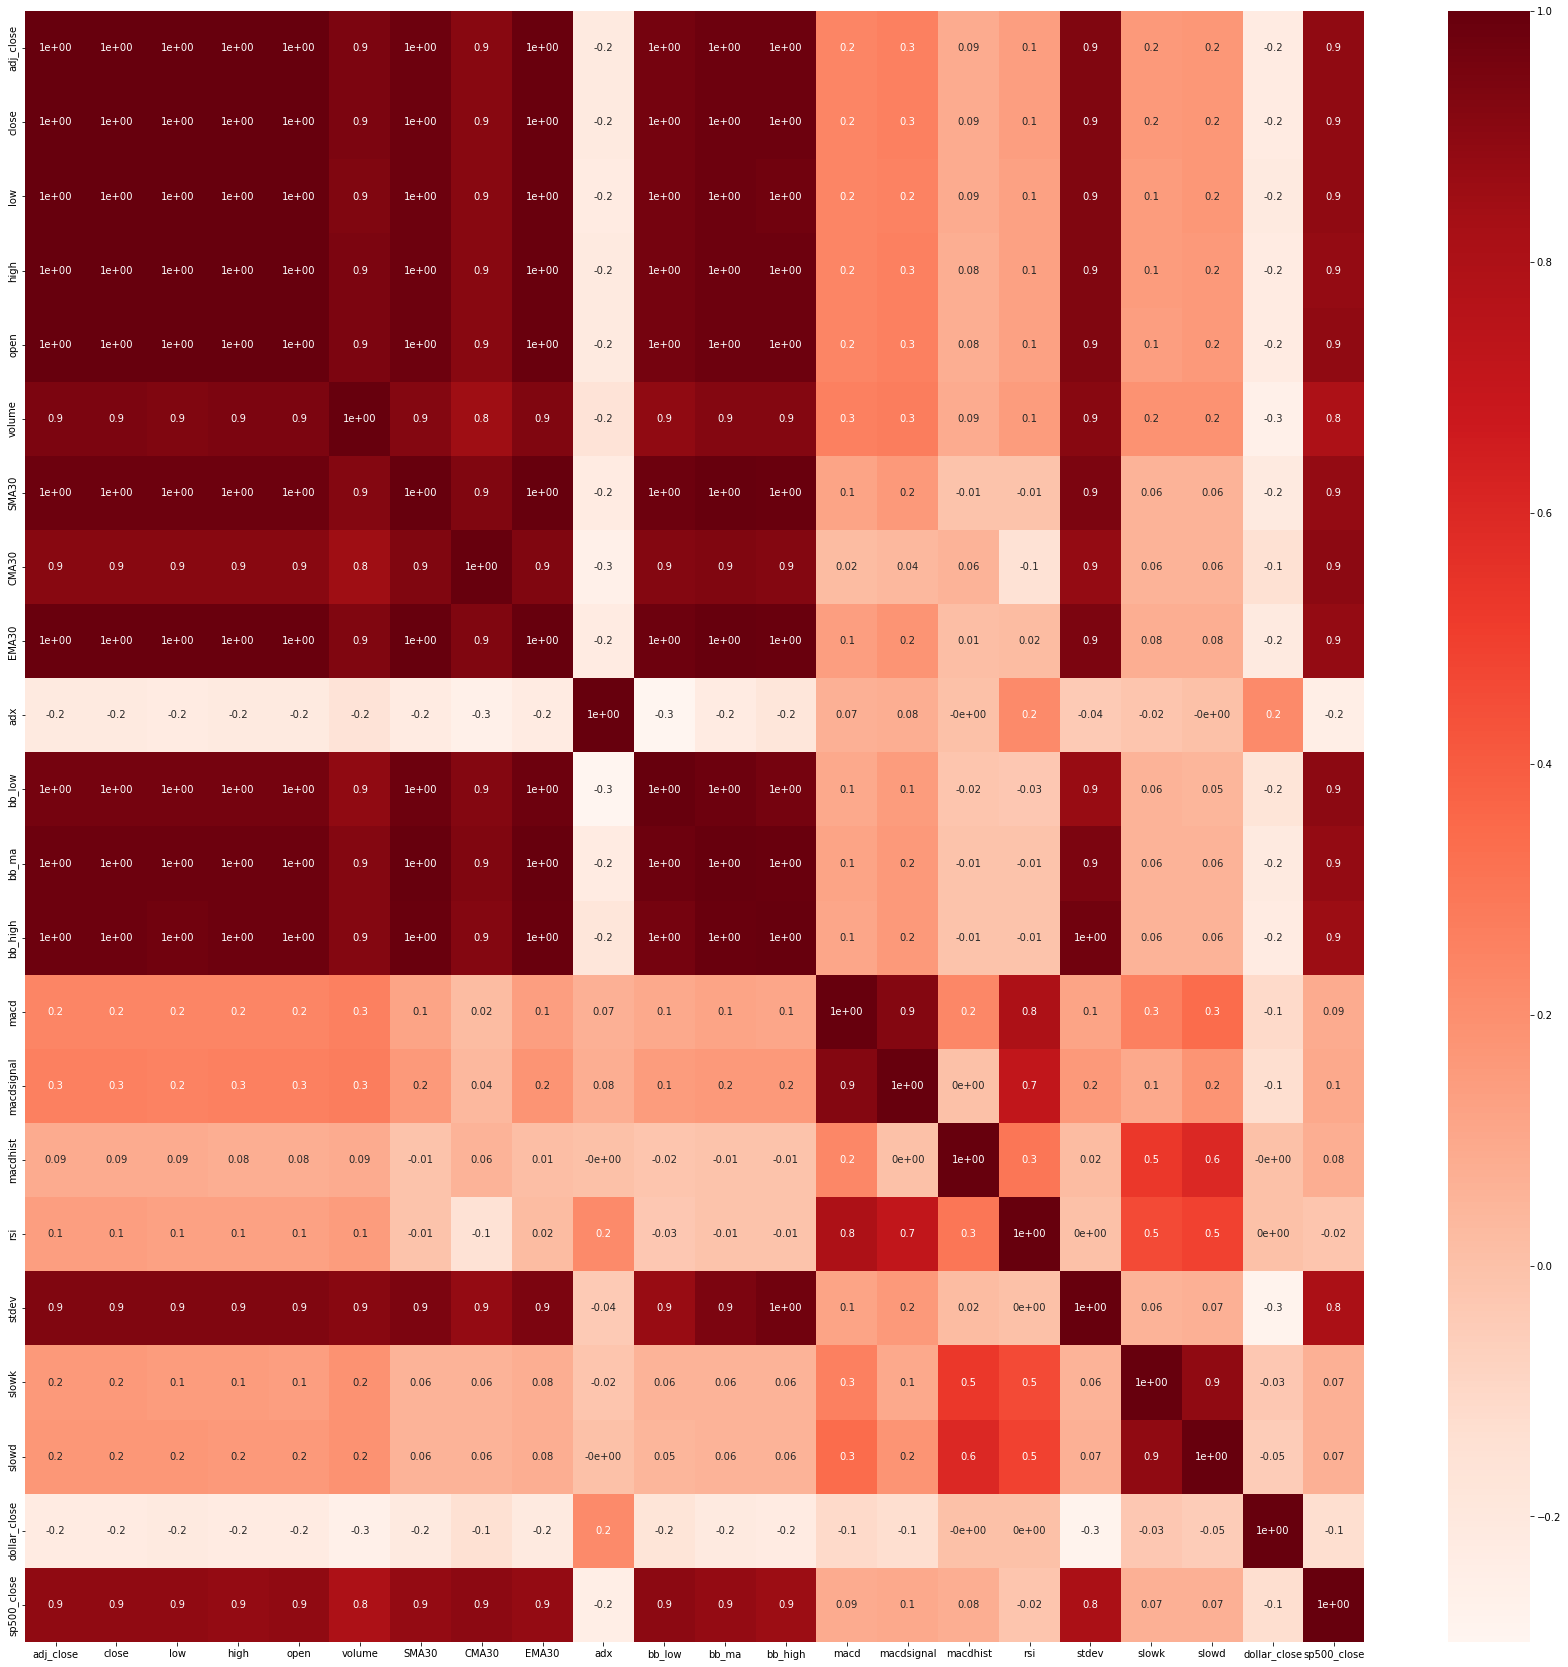

In [4]:
# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(scaled_df.corr(method="spearman"), decimals=2)

def cor_heatmap(cor):
    plt.figure(figsize=(30,30))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()


cor_heatmap(corr)

As we can see high, low, open, SMA30, EMA30 and the Bollinger Bands pretty much all tell the same information and are highly correlated. These variables will then be removed. 

In [5]:
scaled_df.columns

Index(['adj_close', 'close', 'low', 'high', 'open', 'volume', 'SMA30', 'CMA30',
       'EMA30', 'adx', 'bb_low', 'bb_ma', 'bb_high', 'macd', 'macdsignal',
       'macdhist', 'rsi', 'stdev', 'slowk', 'slowd', 'dollar_close',
       'sp500_close'],
      dtype='object')

In [6]:
scaled_df.drop(['low', 'open','SMA30', 'EMA30','bb_low', 'bb_ma', 'bb_high', 'stdev', 'adj_close', 'macdsignal'], axis=1, inplace=True)

# Timeseries CV and Sliding window 

## TimeSeries CV

In [7]:
scaled_df.columns

Index(['close', 'high', 'volume', 'CMA30', 'adx', 'macd', 'macdhist', 'rsi',
       'slowk', 'slowd', 'dollar_close', 'sp500_close'],
      dtype='object')

In [8]:
y = result['close']
X = scaled_df.drop(['close'], axis=1)

In [9]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(X):
        X_train, X_test = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = y[:len(train_index)].values.ravel(), y[len(train_index): (len(train_index)+len(test_index))].values.ravel()

## Hand-Made Sliding Window

In [10]:
y = result
y.reset_index(inplace=True)
X = scaled_df.drop(['close'], axis=1)
X.reset_index(inplace=True)
y['Date'] = pd.to_datetime(y['Date']).dt.date

In [11]:
def train_test_split_time_series(data, num_df, column_date):
    #data: data frame to split
    #num_df: number of differente splits
    #column_date: name of the column that has the Date info
    data[column_date] = pd.to_datetime(data[column_date]).dt.date
    date_split=[]
    max_date = data[column_date].max()
    min_date = data[column_date].min()
    range_date = max_date-min_date
    split_criteria = 0.2/(num_df-1)
    train = 0.6
    test = 0.8
    inicial = 0
    for i in range(num_df):
        list_to_add=[]
        list_to_add.append((min_date + range_date*inicial))
        list_to_add.append((min_date + range_date*train))
        list_to_add.append((min_date + range_date*test))
        train = train + split_criteria
        test = test + split_criteria
        inicial = inicial + split_criteria

        date_split.append(list_to_add)
    
    
    return date_split

In [12]:
date = train_test_split_time_series(X, num_df=3, column_date='Date')

In [13]:
date

[[datetime.date(2017, 12, 18),
  datetime.date(2020, 7, 28),
  datetime.date(2021, 6, 11)],
 [datetime.date(2018, 5, 25),
  datetime.date(2021, 1, 3),
  datetime.date(2021, 11, 17)],
 [datetime.date(2018, 10, 31),
  datetime.date(2021, 6, 11),
  datetime.date(2022, 4, 25)]]

In [14]:
train_1 = X[(X['Date'] >= date[0][0]) & (X['Date'] < date[0][1])]
test_1 = X[(X['Date'] >= date[0][1]) & (X['Date'] < date[0][2])]

y_train_1 = y[(y['Date'] >= date[0][0]) & (y['Date'] < date[0][1])]
y_test_1 = y[(y['Date'] >= date[0][1]) & (y['Date'] < date[0][2])]

In [15]:
def date_to_index(col_name, *args):
    for df in args:
        df.set_index(col_name, inplace = True)

In [16]:
date_to_index('Date', train_1, test_1)

In [17]:
y_train_1 = y_train_1['close']
y_test_1= y_test_1['close']

# Models

## Functions To Apply the Models 

In [23]:
# Models
#Neural Networks
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [24]:
def show_results(df,X_train, X_test, y_train, y_test, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    preds = [y_test]
    count = 0
    # for each model passed as argument
    for arg in args:
        # applies the model
        model_fit = arg.fit(X_train, y_train)
        # predicts training
        y_pred_test = model_fit.predict(X_test)
        # evaluate predictions
        mae = mean_absolute_error(y_test, y_pred_test)
        mse = mean_squared_error(y_test, y_pred_test)
        r2 = r2_score(y_test, y_pred_test)
        preds.append(y_pred_test)
        # store the results in the right row
        df.iloc[count] = mae, mse, r2
        count+=1
    
    fig = px.line(X_test, x = X_test.index, y = preds)
    fig.show()
    return df

## Neural Networks

In [40]:
df = pd.DataFrame(columns = ['MAE', 'MSE', 'R2'], index = ['NN'])

In [41]:
nn_modelo = MLPRegressor()

In [42]:
# applies the model
model_fit = nn_modelo.fit(X_train, y_train)
# predicts training
y_pred_test = model_fit.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)


C:\Users\xicoc\.conda\envs\NOVAIMS\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [43]:
show_results(df, X_train, X_test, y_train, y_test, nn_modelo)

C:\Users\xicoc\.conda\envs\NOVAIMS\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



,MAE,MSE,R2
NN,1.324852,2.618432,0.815863
